<a href="https://colab.research.google.com/github/sycamore-st/adhd-brain-connectivity/blob/main/adhd_brain_connectivity_saliency_with_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ADHD Brain Connectivity Saliency with Deep Learning
**Project Summary**

This script analyzes functional brain connectivity to identify salient brain regions associated with
Attention Deficit Hyperactivity Disorder (ADHD), using resting-state fMRI data from the
WiDS Datathon 2025 competition:
(https://www.kaggle.com/competitions/widsdatathon2025/overview).

It applies a deep learning approach to model and interpret ADHD-related neural patterns, with the
goal of visualizing differences in brain saliency between ADHD and control subjects.


🔧 Model

- **Architecture:** A deep attention-based graph neural network adapted from the
  "Diffusion Kernel Attention Network" by Zhang et al. (TMI 2022) [DOI: 10.1109/TMI.2022.3170701]
- **Modules** include spatial and temporal attention blocks for learning from 200×200 functional connectome matrices
- **Input format:** Each subject's brain connectivity is represented as a 200×200 matrix (full or upper-triangular)
- **Output:** Binary classification logits (ADHD vs. control)


📊 Training and Evaluation

- **Dataset:** Connectome matrices reshaped from upper-triangular vectors or full matrices
  - Each connectome matrix is wrapped into a PyTorch `Dataset` object and accessed via a `DataLoader`
  - Allows for efficient batch processing, optional data augmentation during training, and parallel loading
- **Loss Function:** Cross-entropy loss based on predicted class probabilities
- **Evaluation Metric:** F1 score, to balance precision and recall in binary ADHD classification


🧠 Saliency and Visualization

- Node-level importance is calculated by averaging saliency maps across samples
- Top-30 most salient brain regions are selected for each group
- Visualization:
    - **NetworkX graph:** 2D topological brain graphs with left/right hemisphere coloring and edge classification
    - **Nilearn plot:** Top regions visualized on actual brain using Schaefer 200 MNI coordinates



In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  4 06:34:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   47C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Install PyTorch Geometric first
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.data import Data, DataLoader, Dataset
from torch_geometric.nn import GCNConv


In [8]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model Set up

### Custom Dataset

In [9]:
def augment_connectome(conn, drop_edge_prob=0.1, noise_std=0.01, scale_range=(0.95, 1.05)):
    """
    Augments a 200x200 connectome matrix.

    Args:
        conn (np.array or torch.Tensor): (200, 200) matrix
        drop_edge_prob (float): probability to randomly drop an edge
        noise_std (float): stddev of Gaussian noise to add
        scale_range (tuple): range of scaling factors

    Returns:
        Augmented connectome (same shape)
    """

    if isinstance(conn, torch.Tensor):
        conn = conn.numpy()

    aug_conn = conn.copy()

    # Random edge dropout
    mask = np.random.rand(*aug_conn.shape) < drop_edge_prob
    aug_conn[mask] = 0.0

    # Random Gaussian noise
    noise = np.random.randn(*aug_conn.shape) * noise_std
    aug_conn += noise

    # Random scaling
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    aug_conn *= scale_factor

    # Optional: clip extreme values (optional)
    # aug_conn = np.clip(aug_conn, -1.0, 1.0)

    return aug_conn

class ConnectomeDataset(Dataset):
    def __init__(self, connectomes, labels, training_mode=False):
        """
        connectomes: numpy array of shape [N, 200, 200] (or [N, num_nodes, num_nodes])
        labels: numpy array of shape [N]
        """
        self.connectomes = connectomes
        self.labels = labels
        self.training_mode = training_mode

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        conn = self.connectomes[idx]  # (200, 200)
        label = self.labels[idx]

        if self.training_mode:  # Only augment during training
            conn = augment_connectome(conn)

        node_features = conn.T  # transpose to (features, nodes)
        node_features = node_features[np.newaxis, :, np.newaxis, :]  # (1, C, 1, V)

        node_features = torch.tensor(node_features, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)

        return node_features, label

### DSTANet

In [10]:
# This code is adapted from the repository: Diffusion_kernel_attention_network
#
# Citation:
# Zhang, Jianjia et al. "Diffusion Kernel Attention Network for Brain Disorder Classification."
# IEEE Transactions on Medical Imaging, 2022, 41(10): 2814–2827.
# DOI: https://doi.org/10.1109/TMI.2022.3170701
#
# Source: https://github.com/seuzjj/Diffusion_kernel_attention_network
# License: MIT


import torch
import torch.nn as nn
import math
import numpy as np




def conv_init(conv):
    """
    Initialize a Conv2d layer’s weights using Kaiming normal initialization, which is good for layers
    followed by ReLU activations.
    """

    # mode='fan_out' means the initialization is scaled by the number of output units.
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')


def bn_init(bn, scale):
    """
    To initialize a BatchNorm2d layer
    Sets all scale weights (γ) to scale (commonly 1) and all biases (β) to 0.
    This makes batch norm start as an identity transform: y = x * γ + β = x.
    """

    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)


def fc_init(fc):
    """
    To initialize a Linear (fully connected) layer.
    Xavier normal initialization balances variance across layers,
    helping gradient flow for tanh/sigmoid activations.
    Bias is set to 0.
    """

    nn.init.xavier_normal_(fc.weight)
    nn.init.constant_(fc.bias, 0)


class PositionalEncoding(nn.Module):

    def __init__(self, channel, joint_num, time_len, domain):
        super(PositionalEncoding, self).__init__()
        self.joint_num = joint_num
        self.time_len = time_len

        self.domain = domain

        if domain == "temporal":
            # temporal embedding
            pos_list = []
            for t in range(self.time_len):
                for j_id in range(self.joint_num):
                    pos_list.append(t)
        elif domain == "spatial":
            # spatial embedding
            pos_list = []
            for t in range(self.time_len):
                for j_id in range(self.joint_num):
                    pos_list.append(j_id)

        position = torch.from_numpy(np.array(pos_list)).unsqueeze(1).float()
        # pe = position/position.max()*2 -1
        # pe = pe.view(time_len, joint_num).unsqueeze(0).unsqueeze(0)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(self.time_len * self.joint_num, channel)

        div_term = torch.exp(torch.arange(0, channel, 2).float() *
                             -(math.log(10000.0) / channel))  # channel//2
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.view(time_len, joint_num, channel).permute(2, 0, 1).unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):  # nctv
        x = x + self.pe[:, :, :x.size(2)]
        return x


class STAttentionBlock(nn.Module):
    """
    The STAttentionBlock is a Spatio-Temporal Attention Block designed to model interactions across both nodes (
    spatial) and time steps (temporal) in a brain connectome or skeleton-based data. It’s a key component in deep
    models like ST-GCN, used here to refine features with learned attention mechanisms.
    """

    def __init__(self, in_channels, out_channels, inter_channels, num_subset=3, num_node=25, num_frame=32,
                 kernel_size=1, stride=1, glo_reg_s=True, att_s=True, glo_reg_t=True, att_t=True,
                 use_temporal_att=True, use_spatial_att=True, attentiondrop=0, use_pes=True, use_pet=True):
        super(STAttentionBlock, self).__init__()
        self.inter_channels = inter_channels
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.num_subset = num_subset
        self.glo_reg_s = glo_reg_s
        self.att_s = att_s
        self.glo_reg_t = glo_reg_t
        self.att_t = att_t
        self.use_pes = use_pes
        self.use_pet = use_pet

        pad = int((kernel_size - 1) / 2)
        self.use_spatial_att = use_spatial_att
        if use_spatial_att:
            atts = torch.zeros((1, num_subset, num_node, num_node))
            self.register_buffer('atts', atts)
            self.pes = PositionalEncoding(in_channels, num_node, num_frame, 'spatial')
            self.ff_nets = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, 1, 1, padding=0, bias=True),
                nn.BatchNorm2d(out_channels),
            )
            if att_s:
                self.in_nets = nn.Conv2d(in_channels, 2 * num_subset * inter_channels, 1, bias=True)
                self.alphas = nn.Parameter(torch.ones(1, num_subset, 1, 1), requires_grad=True)
            if glo_reg_s:
                self.attention0s = nn.Parameter(torch.ones(1, num_subset, num_node, num_node) / num_node,
                                                requires_grad=True)

            self.out_nets = nn.Sequential(
                nn.Conv2d(in_channels * num_subset, out_channels, 1, bias=True),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.out_nets = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (1, 3), padding=(0, 1), bias=True, stride=1),
                nn.BatchNorm2d(out_channels),
            )
        self.use_temporal_att = use_temporal_att
        if use_temporal_att:
            attt = torch.zeros((1, num_subset, num_frame, num_frame))
            self.register_buffer('attt', attt)
            self.pet = PositionalEncoding(out_channels, num_node, num_frame, 'temporal')
            self.ff_nett = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, (kernel_size, 1), (stride, 1), padding=(pad, 0), bias=True),
                nn.BatchNorm2d(out_channels),
            )
            if att_t:
                self.in_nett = nn.Conv2d(out_channels, 2 * num_subset * inter_channels, 1, bias=True)
                self.alphat = nn.Parameter(torch.ones(1, num_subset, 1, 1), requires_grad=True)
            if glo_reg_t:
                self.attention0t = nn.Parameter(torch.zeros(1, num_subset, num_frame, num_frame) + torch.eye(num_frame),
                                                requires_grad=True)
            self.out_nett = nn.Sequential(
                nn.Conv2d(out_channels * num_subset, out_channels, 1, bias=True),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.out_nett = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, (7, 1), padding=(3, 0), bias=True, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        if in_channels != out_channels or stride != 1:
            if use_spatial_att:
                self.downs1 = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, bias=True),
                    nn.BatchNorm2d(out_channels),
                )
            self.downs2 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=True),
                nn.BatchNorm2d(out_channels),
            )
            if use_temporal_att:
                self.downt1 = nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, 1, 1, bias=True),
                    nn.BatchNorm2d(out_channels),
                )
            self.downt2 = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, (kernel_size, 1), (stride, 1), padding=(pad, 0), bias=True),
                nn.BatchNorm2d(out_channels),
            )
        else:
            if use_spatial_att:
                self.downs1 = lambda x: x
            self.downs2 = lambda x: x
            if use_temporal_att:
                self.downt1 = lambda x: x
            self.downt2 = lambda x: x

        self.soft = nn.Softmax(-2)
        self.tan = nn.Tanh()
        self.relu = nn.LeakyReLU(0.1)
        self.drop = nn.Dropout(attentiondrop)

    def forward(self, x):

        N, C, T, V = x.size()
        if self.use_spatial_att:
            attention = self.atts
            if self.use_pes:
                y = self.pes(x)
            else:
                y = x
            if self.att_s:
                q, k = torch.chunk(self.in_nets(y).view(N, 2 * self.num_subset, self.inter_channels, T, V), 2,
                                   dim=1)  # nctv -> n num_subset c'tv
                attention = attention + self.tan(
                    torch.einsum('nsctu,nsctv->nsuv', [q, k]) / (self.inter_channels * T)) * self.alphas
            if self.glo_reg_s:
                attention = attention + self.attention0s.repeat(N, 1, 1, 1)
            attention = self.drop(attention)
            y = torch.einsum('nctu,nsuv->nsctv', [x, attention]).contiguous() \
                .view(N, self.num_subset * self.in_channels, T, V)
            y = self.out_nets(y)  # nctv
            y = self.relu(self.downs1(x) + y)
            y = self.ff_nets(y)
            y = self.relu(self.downs2(x) + y)
        else:
            y = self.out_nets(x)
            y = self.relu(self.downs2(x) + y)

        if self.use_temporal_att:
            attention = self.attt
            if self.use_pet:
                z = self.pet(y)
            else:
                z = y
            if self.att_t:
                q, k = torch.chunk(self.in_nett(z).view(N, 2 * self.num_subset, self.inter_channels, T, V), 2,
                                   dim=1)  # nctv -> n num_subset c'tv
                attention = attention + self.tan(
                    torch.einsum('nsctv,nscqv->nstq', [q, k]) / (self.inter_channels * V)) * self.alphat
            if self.glo_reg_t:
                attention = attention + self.attention0t.repeat(N, 1, 1, 1)
            attention = self.drop(attention)
            z = torch.einsum('nctv,nstq->nscqv', [y, attention]).contiguous() \
                .view(N, self.num_subset * self.out_channels, T, V)
            z = self.out_nett(z)  # nctv

            z = self.relu(self.downt1(y) + z)

            z = self.ff_nett(z)

            z = self.relu(self.downt2(y) + z)
        else:
            z = self.out_nett(y)
            z = self.relu(self.downt2(y) + z)
        return z


class STKernelAttentionBlock(nn.Module):
    """
    The STKernelAttentionBlock is a core component in spatio-temporal attention networks for analyzing data
    structured in space (nodes/regions) and time (frames). This class implements both spatial and temporal attention
    using kernel-based mechanisms and optional diffusion steps to enhance receptive fields.
    """

    def __init__(
            self,
            in_channels,
            out_channels,
            inter_channels,
            num_subset: int = 3,
            num_node: int = 25,
            num_frame: int = 32,
            kernel_size: int = 1,
            stride: int = 1,
            glo_reg_s: bool = True,
            att_s: bool = True,
            glo_reg_t: bool = True,
            att_t: bool = True,
            use_temporal_att: bool = True,
            use_spatial_att: bool = True,
            attentiondrop: int = 0,
            use_pes: bool = True,
            use_pet: bool = True,
            diffusion: int = 0
    ):

        """
        in_channels, out_channels, inter_channels: control feature map sizes.
        num_node, num_frame: number of brain regions and time steps.
        num_subset: number of attention heads.
        Flags like att_s, att_t, use_pet, glo_reg_s, etc., determine which mechanisms are activated.
        diffusion: number of propagation layers in attention (0–5).

        If use_spatial_att is True:
        •	self.theta: trainable scaling for the RBF kernel.
        •	self.pes: positional encoding over spatial structure.
        •	self.in_nets: projects input for query-key pairs (if attention is enabled).
        •	self.attention0s: global regularizer for spatial attention.
        •	self.out_nets, self.ff_nets: process and output updated features.
        """

        super(STKernelAttentionBlock, self).__init__()
        self.inter_channels = inter_channels
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.num_subset = num_subset
        self.glo_reg_s = glo_reg_s
        self.att_s = att_s
        self.glo_reg_t = glo_reg_t
        self.att_t = att_t
        self.use_pes = use_pes
        self.use_pet = use_pet
        self.diffusion = diffusion

        pad = int((kernel_size - 1) / 2)
        self.use_spatial_att = use_spatial_att
        self.dfw2 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.dfw3 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.dfw4 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.dfw5 = nn.Parameter(torch.ones(1), requires_grad=True)

        if use_spatial_att:
            self.theta = torch.nn.Parameter(torch.zeros((1, num_subset, 1, 1)))
            atts = torch.zeros((1, num_subset, num_node, num_node))
            self.register_buffer('atts', atts)
            self.pes = PositionalEncoding(in_channels, num_node, num_frame, 'spatial')
            self.ff_nets = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, 1, 1, padding=0, bias=True),
                nn.BatchNorm2d(out_channels),
            )
            if att_s:
                self.in_nets = nn.Conv2d(in_channels, 2 * num_subset * inter_channels, 1, bias=True)
                self.alphas = nn.Parameter(torch.ones(1, num_subset, 1, 1), requires_grad=True)
            if glo_reg_s:
                self.attention0s = nn.Parameter(
                    torch.ones(1, num_subset, num_node, num_node) / num_node,
                    requires_grad=True
                )

            self.out_nets = nn.Sequential(
                nn.Conv2d(in_channels * num_subset, out_channels, 1, bias=True),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.out_nets = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (1, 3), padding=(0, 1), bias=True, stride=1),
                nn.BatchNorm2d(out_channels),
            )
        self.use_temporal_att = use_temporal_att
        if use_temporal_att:
            attt = torch.zeros((1, num_subset, num_frame, num_frame))
            self.register_buffer('attt', attt)
            self.pet = PositionalEncoding(out_channels, num_node, num_frame, 'temporal')
            self.ff_nett = nn.Sequential(
                nn.Conv2d(
                    out_channels,
                    out_channels,
                    (kernel_size, 1),
                    (stride, 1),
                    padding=(pad, 0),
                    bias=True
                ),
                nn.BatchNorm2d(out_channels),
            )
            if att_t:
                self.in_nett = nn.Conv2d(
                    out_channels,
                    2 * num_subset * inter_channels,
                    1,
                    bias=True
                )
                self.alphat = nn.Parameter(
                    torch.ones(1, num_subset, 1, 1),
                    requires_grad=True
                )
            if glo_reg_t:
                self.attention0t = nn.Parameter(
                    torch.zeros(1, num_subset, num_frame, num_frame) + torch.eye(num_frame),
                    requires_grad=True
                )
            self.out_nett = nn.Sequential(
                nn.Conv2d(out_channels * num_subset, out_channels, 1, bias=True),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.out_nett = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, (7, 1), padding=(3, 0), bias=True, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        if in_channels != out_channels or stride != 1:
            if use_spatial_att:
                self.downs1 = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, bias=True),
                    nn.BatchNorm2d(out_channels),
                )
            self.downs2 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=True),
                nn.BatchNorm2d(out_channels),
            )
            if use_temporal_att:
                self.downt1 = nn.Sequential(
                    nn.Conv2d(out_channels, out_channels, 1, 1, bias=True),
                    nn.BatchNorm2d(out_channels),
                )
            self.downt2 = nn.Sequential(
                nn.Conv2d(
                    out_channels, out_channels, (kernel_size, 1), (stride, 1),
                    padding=(pad, 0),
                    bias=True
                ),
                nn.BatchNorm2d(out_channels),
            )
        else:
            if use_spatial_att:
                self.downs1 = lambda x: x
            self.downs2 = lambda x: x
            if use_temporal_att:
                self.downt1 = lambda x: x
            self.downt2 = lambda x: x

        self.soft = nn.Softmax(-2)
        self.tan = nn.Tanh()
        self.relu = nn.LeakyReLU(0.1)
        self.drop = nn.Dropout(attentiondrop)

    def forward(self, x):

        N, C, T, V = x.size()
        if self.use_spatial_att:
            attention = self.atts
            if self.use_pes:
                y = self.pes(x)
            else:
                y = x
            if self.att_s:
                y = y.permute(0, 3, 1, 2).contiguous()
                dism = torch.cdist(
                    y.view(y.shape[0], y.shape[1], y.shape[2] * y.shape[3]),
                    y.view(y.shape[0], y.shape[1], y.shape[2] * y.shape[3]),
                    p=2
                )
                dism = torch.pow(dism / (C * T), 2)
                dsexp = torch.exp(self.theta)
                dism = torch.unsqueeze(dism, 1).repeat(1, self.num_subset, 1, 1)
                kernel_atten = torch.exp(-1 * dsexp * dism)

                if self.diffusion == 2:
                    attention_df2 = torch.matmul(kernel_atten, kernel_atten) / kernel_atten.size()[3]
                    kernel_atten = 0.5 * kernel_atten + attention_df2 * self.dfw2 * 0.5
                elif self.diffusion == 3:
                    attention_df2 = torch.matmul(kernel_atten, kernel_atten) / kernel_atten.size()[3]
                    attention_df3 = torch.matmul(attention_df2, kernel_atten) / kernel_atten.size()[3]
                    kernel_atten = 0.4 * kernel_atten + attention_df2 * self.dfw2 * 0.3 + attention_df3 * self.dfw3 * 0.3
                elif self.diffusion == 4:
                    attention_df2 = torch.matmul(kernel_atten, kernel_atten) / kernel_atten.size()[3]
                    attention_df3 = torch.matmul(attention_df2, kernel_atten) / kernel_atten.size()[3]
                    attention_df4 = torch.matmul(attention_df3, kernel_atten) / kernel_atten.size()[3]
                    kernel_atten = 0.25 * kernel_atten + attention_df2 * self.dfw2 * 0.25 + attention_df3 * self.dfw3 * 0.25 + attention_df4 * self.dfw4 * 0.25
                elif self.diffusion == 5:
                    attention_df2 = torch.matmul(kernel_atten, kernel_atten) / kernel_atten.size()[3]
                    attention_df3 = torch.matmul(attention_df2, kernel_atten) / kernel_atten.size()[3]
                    attention_df4 = torch.matmul(attention_df3, kernel_atten) / kernel_atten.size()[3]
                    attention_df5 = torch.matmul(attention_df3, kernel_atten) / kernel_atten.size()[3]
                    kernel_atten = 0.2 * kernel_atten + attention_df2 * self.dfw2 * 0.2 + attention_df3 * self.dfw3 * 0.2 + attention_df4 * self.dfw4 * 0.2 + attention_df5 * self.dfw5 * 0.2

                attention = attention + self.tan(kernel_atten) * self.alphas

            if self.glo_reg_s:
                attention = attention + self.attention0s.repeat(N, 1, 1, 1)
            attention = self.drop(attention)
            y = torch.einsum('nctu,nsuv->nsctv', [x, attention]).contiguous() \
                .view(N, self.num_subset * self.in_channels, T, V)
            y = self.out_nets(y)  # nctv
            y = self.relu(self.downs1(x) + y)
            y = self.ff_nets(y)
            y = self.relu(self.downs2(x) + y)
        else:
            y = self.out_nets(x)
            y = self.relu(self.downs2(x) + y)

        if self.use_temporal_att:
            attention = self.attt
            if self.use_pet:
                z = self.pet(y)
            else:
                z = y
            if self.att_t:
                q, k = torch.chunk(self.in_nett(z).view(N, 2 * self.num_subset, self.inter_channels, T, V), 2,
                                   dim=1)  # nctv -> n num_subset c'tv
                attention = attention + self.tan(
                    torch.einsum('nsctv,nscqv->nstq', [q, k]) / (self.inter_channels * V)) * self.alphat
            if self.glo_reg_t:
                attention = attention + self.attention0t.repeat(N, 1, 1, 1)
            attention = self.drop(attention)
            z = torch.einsum('nctv,nstq->nscqv', [y, attention]).contiguous() \
                .view(N, self.num_subset * self.out_channels, T, V)
            z = self.out_nett(z)  # nctv

            z = self.relu(self.downt1(y) + z)

            z = self.ff_nett(z)

            z = self.relu(self.downt2(y) + z)
        else:
            z = self.out_nett(y)
            z = self.relu(self.downt2(y) + z)
        return z


"""
	Input format: (N, M, C, T, V) → typically (batch, 1, 1, 1, 200) for your static brain graph
	Backbone: Stack of spatio-temporal attention layers
	Output: Class logits for classification
	Use case: Works for datasets with graph-structured spatio-temporal data — like functional connectomes or human actions.
"""


class DSTANet(nn.Module):
    def __init__(
            self,
            num_class: int = 60,
            num_point: int = 25,
            num_frame: int = 32,
            num_subset: int = 3,
            num_channel: int = 3,
            dropout: float = 0.,
            dropout2d: float = 0.,
            config=None,
            glo_reg_s: bool = True,
            att_s: bool = True,
            glo_reg_t: bool = False,
            att_t: bool = True,
            use_temporal_att: bool = True,
            use_spatial_att: bool = True,
            attentiondrop: int = 0,
            use_pet: bool = True,
            use_pes: bool = True,
            kernelattention: bool = True,
            diffusion: int = 0
    ):
        """
        :param num_class: Output classes (e.g., ADHD vs Control = 2)
        :param num_point: Number of spatial nodes (e.g., 200 brain regions)
        :param num_frame: Number of temporal frames (useful for time series or multiple frames)
        :param num_subset: Number of adjacency subsets (for graph convolution branches)
        :param num_channel: Number of input features (e.g., 1 for static features, 3 for RGB or other channels)
        :param dropout: Regularization
        :param dropout2d: Regularization
        """

        super(DSTANet, self).__init__()

        self.out_channels = config[-1][1]
        in_channels = config[0][0]

        # Maps input channel (num_channel) to the internal representation (in_channels from config), using a 1x1
        # convolution.
        self.input_map = nn.Sequential(
            nn.Conv2d(num_channel, in_channels, 1),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.1),
        )

        param = {
            'num_node': num_point,
            'num_subset': num_subset,
            'glo_reg_s': glo_reg_s,
            'att_s': att_s,
            'glo_reg_t': glo_reg_t,
            'att_t': att_t,
            'use_spatial_att': use_spatial_att,
            'use_temporal_att': use_temporal_att,
            'use_pet': use_pet,
            'use_pes': use_pes,
            'attentiondrop': attentiondrop,
            'diffusion': diffusion
        }
        # A sequence of blocks (e.g., STAttentionBlock or STKernelAttentionBlock) to model spatio-temporal attention.
        # stride can downsample the temporal dimension, allowing for hierarchical processing.

        self.graph_layers = nn.ModuleList()
        for index, (in_channels, out_channels, inter_channels, stride) in enumerate(config):
            if not kernelattention:  # use original linear attention
                self.graph_layers.append(
                    STAttentionBlock(
                        in_channels,
                        out_channels,
                        inter_channels,
                        stride=stride,
                        num_frame=num_frame,
                        **param
                    )
                )
            else:  # use kernel attention. if diffusion >1, diffusion will be applied
                self.graph_layers.append(
                    STKernelAttentionBlock(
                        in_channels,
                        out_channels,
                        inter_channels,
                        stride=stride,
                        num_frame=num_frame,
                        **param
                    )
                )
            num_frame = int(num_frame / stride + 0.5)

        # Final classifier
        self.fc = nn.Linear(self.out_channels, num_class)

        self.drop_out = nn.Dropout(dropout)
        self.drop_out2d = nn.Dropout2d(dropout2d)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m, 1)
            elif isinstance(m, nn.Linear):
                fc_init(m)

    def forward(self, x):
        """
        :param x: N M C T V
        :return: classes scores
        """

        # Assumes x has shape: (Batch, Person, Channel, Time, Nodes)
        # Reshapes it to (Batch × Person, Channel, Time, Nodes) for processing.
        N, M, C, T, V = x.shape
        x = x.permute(0, 1, 4, 2, 3).contiguous().view(N * M, C, T, V)

        # Maps to model input channel size.
        x = self.input_map(x)

        # Pass through graph attention layers
        # Each layer captures different aspects of spatial and temporal attention.
        for i, m in enumerate(self.graph_layers):
            x = m(x)

        # NM, C, T, V
        x = x.view(N, M, self.out_channels, -1)  # reshape back
        x = x.permute(0, 1, 3, 2).contiguous().view(N, -1, self.out_channels, 1)  # whole channels of one spatial
        x = self.drop_out2d(x)
        x = x.mean(3).mean(1)
        x = self.drop_out(x)  # whole spatial of one channel
        return self.fc(x)

### Training Function

In [11]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    acc = correct / total
    return avg_loss, acc

### Evaluation Function

In [12]:
from sklearn.metrics import f1_score

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    acc = correct / total
    return avg_loss, f1_score(labels.cpu(), preds.cpu())

## Main Train Loop

#### Data Loading

In [13]:
# Loading function
import os
from typing import Literal

KEY_COL = 'participant_id'

def get_data_subset(
        mode: Literal['train', 'test'],
        subset: Literal['categorical', 'quantitative', 'connectome', 'solution'],
):
    MODE = mode.upper()

    if mode == 'train':
        file_name = {
            'categorical': f'/content/drive/MyDrive/Colab Notebooks/WiDS-2025/TRAIN_CATEGORICAL_METADATA_new.xlsx',
            'quantitative': f'/content/drive/MyDrive/Colab Notebooks/WiDS-2025/TRAIN_QUANTITATIVE_METADATA_new.xlsx',
            'connectome': f'/content/drive/MyDrive/Colab Notebooks/WiDS-2025/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv',
            'solution': f'/content/drive/MyDrive/Colab Notebooks/WiDS-2025/TRAINING_SOLUTIONS.xlsx'
        }.get(subset, lambda a: a)
    else:
        file_name = {
            'categorical': f'/content/drive/MyDrive/Colab Notebooks/WiDS-2025/TEST_CATEGORICAL.xlsx',
            'quantitative': f'/content/drive/MyDrive/Colab Notebooks/WiDS-2025/TEST_QUANTITATIVE_METADATA.xlsx',
            'connectome': f'/content/drive/MyDrive/Colab Notebooks/WiDS-2025/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv'
        }.get(subset, lambda a: a)

    pd_func = pd.read_excel if file_name.endswith('.xlsx') else pd.read_csv

    return pd_func(
        os.path.join(file_name)
    )

In [14]:
n_nodes = 200
batch_size = 32

dataset = pd.merge(
    get_data_subset(mode='train', subset='connectome'),
    get_data_subset(mode='train', subset='solution'),
    how='left',
    on=KEY_COL
)

node_cols = list(
    dataset.columns.difference(
        [
            'ADHD_Outcome',
            'Sex_F',
            KEY_COL
        ]
    )
)

connectomes_df = dataset[node_cols]
pred_df = get_data_subset(mode='test', subset='connectome')

#### Data Processing

In [15]:
# Processing function
def upper_to_symmetric(vec, size=200):
    mat = np.zeros((size, size))
    upper_idx = np.triu_indices(size, k=1)
    mat[upper_idx] = vec
    mat = mat + mat.T
    return mat

def process_connectome_data(
        connectomes_1d_df: pd.DataFrame
) -> np.array:
    """
    This function converts 1D representations of brain connectivity matrices into their full 2D (200x200) matrix forms,
    which are easier to analyze and visualize for brain network analysis tasks.
    """

    processed_connectomes = []
    for idx, row in connectomes_1d_df.iterrows():
        connectome_1d = row.loc[node_cols].astype(float).values

        if len(connectome_1d) == 40000:
            row_matrix = np.array(connectome_1d).reshape(200, 200)
        elif len(connectome_1d) == 19900:
            row_matrix = upper_to_symmetric(connectome_1d)
        else:
            raise ValueError(
                f"Unknown connectome length {len(connectome_1d)} "
                f"— expected 40000 or 19900."
            )

        processed_connectomes.append(row_matrix)

    return np.array(processed_connectomes)  # shape [N, 200, 200]

In [16]:
label_col = 'ADHD_Outcome'
labels = dataset[label_col].values

connectomes = process_connectome_data(connectomes_df)
pred_connectomes = process_connectome_data(pred_df[node_cols])

#### Split train/test

**Why DataLoader?**
- **Mini-batch training:**	Deep learning models are usually trained in batches (e.g., 32 samples at a time) instead of feeding the entire dataset at once. This balances memory usage and gradient updates.

- **Shuffling:** (during training)	shuffle=True ensures the model doesn’t learn from the order of the data, which could cause overfitting or learning bias.

- **Efficient I/O:**	It loads data on the fly, rather than all at once, preventing memory overload.

- **Works with custom datasets:**	It can wrap our custom Dataset class (like ConnectomeDataset) and knows how to call __getitem__ and __len__.

- **Iterator behavior:**	We can loop over a DataLoader with `for inputs, labels in loader:` syntax.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    connectomes, labels, test_size=0.2, random_state=42
)

pred_df[label_col] = 0

train_dataset = ConnectomeDataset(X_train, y_train)
test_dataset = ConnectomeDataset(X_test, y_test)
pred_dataset = ConnectomeDataset(
    connectomes,
    pred_df[label_col].values
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
pred_loader = DataLoader(pred_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### Training


In [18]:
# Model config
config = [
    [64, 64, 16, 1],
    [64, 128, 32, 1],
    [128, 128, 32, 1],
]

# config = [
#     [64, 64, 16, 1],
#     [64, 128, 32, 1],
#     [128, 256, 64, 1],
#     [256, 256, 64, 1],
#     [256, 256, 64, 1]
# ]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DSTANet(
    num_class=2,
    num_point=200,
    num_frame=1,
    num_channel=200,
    config=config,
    dropout=0.5,
    dropout2d=0.5
)
model = model.to(device)

# Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [19]:
best_score = 0
best_model = None

for epoch in range(1, 16):  # 16 epochs
    train_loss, train_score = train(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )
    test_loss, test_score = evaluate(
        model,
        test_loader,
        criterion,
        device
    )

    avg_score = (train_score + test_score)/2

    print(
        f"Epoch {epoch}: Train Loss {train_loss:.4f}, Train f1_score {train_score:.4f} | "
        f"Test Loss {test_loss:.4f}, Test f1_score {test_score:.4f}"
    )

    # Save best model
    if test_score > best_score:
        best_score = avg_score
        best_model = model
        torch.save(model.state_dict(), 'best_dstanet_model.pth')
        print(
            f"Saved new best model at epoch {epoch} "
            f"with Test f1_score {test_score:.4f}"
        )

Epoch 1: Train Loss 1.1035, Train f1_score 0.5979 | Test Loss 0.9389, Test f1_score 0.8824
Saved new best model at epoch 1 with Test f1_score 0.8824
Epoch 2: Train Loss 1.0218, Train f1_score 0.6113 | Test Loss 0.7467, Test f1_score 0.8750
Saved new best model at epoch 2 with Test f1_score 0.8750
Epoch 3: Train Loss 0.8840, Train f1_score 0.6392 | Test Loss 0.8396, Test f1_score 0.8485
Saved new best model at epoch 3 with Test f1_score 0.8485
Epoch 4: Train Loss 0.8376, Train f1_score 0.6680 | Test Loss 0.8384, Test f1_score 0.7742
Saved new best model at epoch 4 with Test f1_score 0.7742
Epoch 5: Train Loss 0.7497, Train f1_score 0.6557 | Test Loss 0.8160, Test f1_score 0.8485
Saved new best model at epoch 5 with Test f1_score 0.8485
Epoch 6: Train Loss 0.6654, Train f1_score 0.6866 | Test Loss 0.9859, Test f1_score 0.7857
Saved new best model at epoch 6 with Test f1_score 0.7857
Epoch 7: Train Loss 0.5844, Train f1_score 0.7423 | Test Loss 0.8698, Test f1_score 0.9032
Saved new best 

#### Predicting

In [20]:
pred_y = []
with torch.no_grad():
  for inputs, labels in pred_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = best_model(inputs)
      loss = criterion(outputs, labels)
      preds = outputs.argmax(dim=1)
      pred_y.extend(preds.cpu().numpy())

pred_df[label_col] = pred_y

### Visualization

#### Compute model-derived saliency maps
**Purpose:**

To identify which brain regions are most influential in the model’s classification decision, based on gradients.

**Steps:**
-	`inputs.requires_grad = True`: allows gradient tracking wrt input features.
-	`loss.backward()`: computes gradient of loss wrt input → gives saliency.
-	`inputs.grad.data.abs()`: takes absolute value to capture importance, regardless of direction.
-	`np.concatenate(...)` → `np.mean(...)`: aggregates saliency across the dataset for interpretability.

In [21]:
def compute_saliency(
        model,
        data_loader,
        device
):
    model.eval()

    all_saliency_maps = []

    for inputs, labels in data_loader:

        inputs = inputs.to(device)

        # if inputs.dim() == 4:
        #     inputs = inputs.unsqueeze(1)

        inputs.requires_grad = True  # allow gradient wrt input

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        loss = torch.nn.functional.cross_entropy(outputs, preds)  # focus on predicted class

        model.zero_grad()
        loss.backward()

        # Gradient of loss w.r.t input
        saliency = inputs.grad.data.abs().cpu().numpy()  # take absolute value of gradients
        all_saliency_maps.append(saliency)

    all_saliency_maps = np.concatenate(all_saliency_maps, axis=0)

    # Average across samples
    avg_saliency = np.mean(all_saliency_maps, axis=0)

    # squeeze unused dimensions
    avg_saliency = np.squeeze(avg_saliency)

    return avg_saliency

#### Extract and contrast connectomes of ADHD vs. controls
Compute:
- One average ADHD connectome
- One average Control connectome
- And separately, the saliency maps for each group.

In [22]:
pos_label = []
neg_label = []
for idx, l in enumerate(train_dataset.labels):
    if l == 1:
        pos_label.extend([idx])
    else:
        neg_label.extend([idx])

adhd_connectomes = train_dataset.connectomes[pos_label]
control_connectomes = train_dataset.connectomes[neg_label]

avg_adhd = np.mean(adhd_connectomes, axis=0)
avg_control = np.mean(control_connectomes, axis=0)
diff = avg_adhd - avg_control

In [23]:
adhd_dataset = ConnectomeDataset(adhd_connectomes, [1] * len(adhd_connectomes))
control_dataset = ConnectomeDataset(control_connectomes, [0] * len(control_connectomes))

adhd_loader = DataLoader(adhd_dataset, batch_size=32, shuffle=False)
control_loader = DataLoader(control_dataset, batch_size=32, shuffle=False)

avg_saliency_adhd = compute_saliency(model, adhd_loader, device)  # shape: (N_adhd, 200)
avg_saliency_control = compute_saliency(model, control_loader, device)  # shape: (N_control, 200)

importance_matrix = {
    'adhd': {
        'connectome': avg_adhd,
        'saliency': avg_saliency_adhd
    },
    'control': {
        'connectome': avg_control,
        'saliency': avg_saliency_control
    }
}

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


####  Load Schaefer atlas MNI coordinates
- Schaefer atlas gives anatomical brain region ROIs.
- We need MNI coordinates to plot them on brain images.

In [24]:
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn import datasets, plotting
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [25]:
# Download the Schaefer 200-region atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=1)
# Extract the 3D MNI coordinates of each ROI (node)
coords = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)
np.savetxt("schaefer200_coords.txt", coords)

[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/schaefer_2018

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_7Networks_order.txt ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.
nii.gz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

In [26]:
# Load coordinates and region names
atlas = fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7)
coordinates = np.loadtxt("schaefer200_coords.txt")
node_names = list(atlas.labels)  # Schaefer region names

[get_dataset_dir] Dataset found in /root/nilearn_data/schaefer_2018

#### Visualize key brain regions and edges in both abstract (NetworkX) and anatomical (MNI-space) ways

**NetworkX Visualization (on 2D plane)**

How:
- Top-30 salient nodes are selected by averaged saliency.
- Graph edges drawn between highly connected pairs (|weight| > 0.4).
- Node color = hemisphere (left/right), edge color = intra/inter-hemisphere.
- label_dict adds readable brain region labels.

Insight:
- This shows what the model focuses on structurally — we can see inter-region interactions.

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


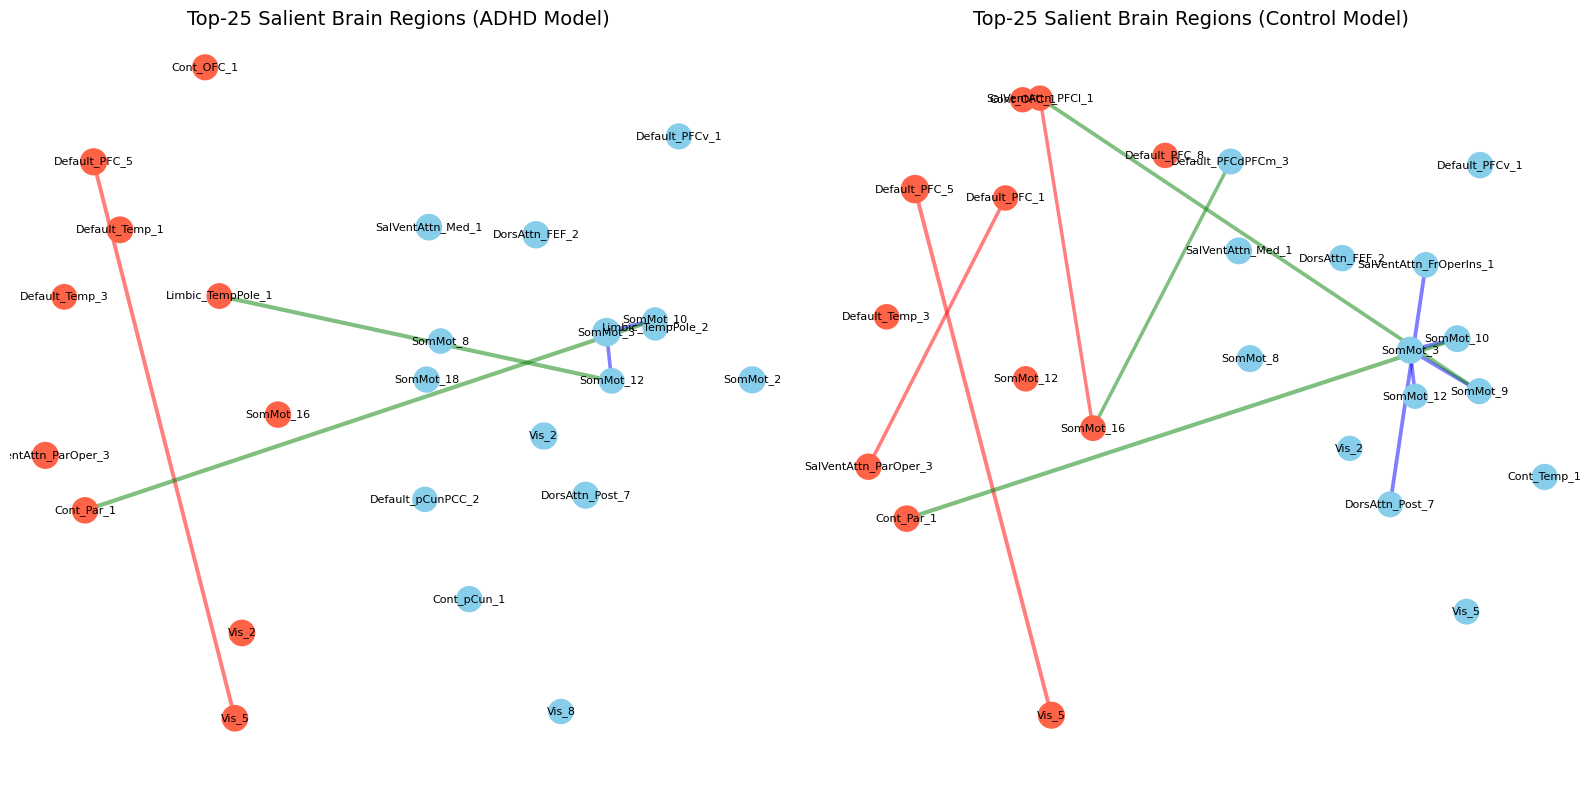

In [27]:
top_k = 25

fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

for idx, (k, connectome_matrix_dict) in enumerate(importance_matrix.items()):
    ax = axes[idx]

    connectome_matrix = connectome_matrix_dict['connectome']
    avg_saliency = connectome_matrix_dict['saliency']



    title = f'Top-{top_k} Salient Brain Regions (ADHD Model)' if k == 'adhd' else f'Top-{top_k} Salient Brain Regions (Control Model)'


    node_importance = avg_saliency.mean(axis=0) / avg_saliency.max()
    top_node_indices = np.argsort(-node_importance)[:top_k]

    # === Build Graph ===
    G = nx.Graph()
    for i in top_node_indices:
        G.add_node(i, label=node_names[i], size=100 + 400 * node_importance[i])

    threshold = 0.45
    for i in top_node_indices:
        for j in top_node_indices:
            if i < j and abs(connectome_matrix[i, j]) > threshold:
                G.add_edge(i, j, weight=abs(connectome_matrix[i, j]))

    node_pos = {i: coordinates[i][:2] for i in top_node_indices}

    nodes = G.nodes()
    nodes_list = list(nodes)
    node_sizes = [G.nodes[n]['size'] for n in nodes]
    node_colors = [
        'tomato' if coordinates[n][0] < 0 else 'skyblue'
        for n in nodes_list
    ]
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = [1 + 2 * (w / max(edge_weights)) for w in edge_weights]

    edge_colors = []
    for u, v in G.edges():
        x_u, x_v = coordinates[u][0], coordinates[v][0]
        if x_u < 0 and x_v < 0:
            edge_colors.append('red')  # left-left
        elif x_u >= 0 and x_v >= 0:
            edge_colors.append('blue')  # right-right
        else:
            edge_colors.append('green')

    nx.draw_networkx_nodes(
        G,
        node_pos,
        nodelist=nodes_list,
        node_size=node_sizes,
        node_color=node_colors,
        cmap='Reds',
        ax=ax
    )

    nx.draw_networkx_edges(
        G,
        node_pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.5,
        ax=ax
    )

    label_dict = {
        n: G.nodes[n]['label'].decode().replace("7Networks_", "").replace("RH_", "").replace("LH_", "")
        # .split("_")[0]
        if 'label' in G.nodes[n] else str(n)
        for n in nodes
    }
    nx.draw_networkx_labels(
        G,
        node_pos,
        labels=label_dict,
        font_size=8,
        ax=ax,
        verticalalignment='center',
        horizontalalignment='center',
        # bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2')  # helps improve legibility
    )

    ax.set_title(title, fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

**Anatomical Brain Visualization (MNI plot)**

How:
- Provides an anatomically correct plot over a brain template using nilearn.
- Nodes are placed at real MNI coordinates.
- Top 30 nodes are highlighted based on saliency.
- Edges thresholded at the 97.5 percentile of strength.

Insight:
- This version maps model attention back onto the brain, aiding neuroscientific interpretability.

<ipython-input-28-d2506d9cac52>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


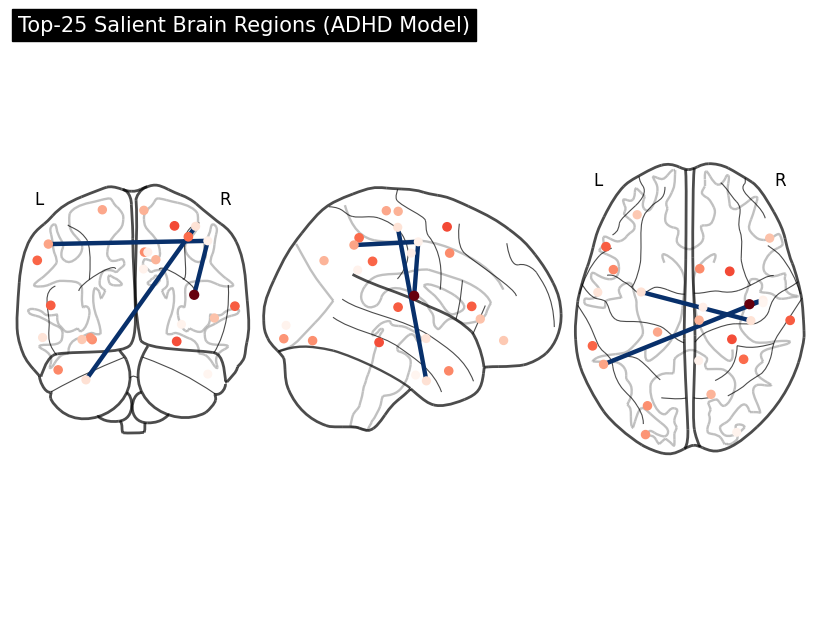

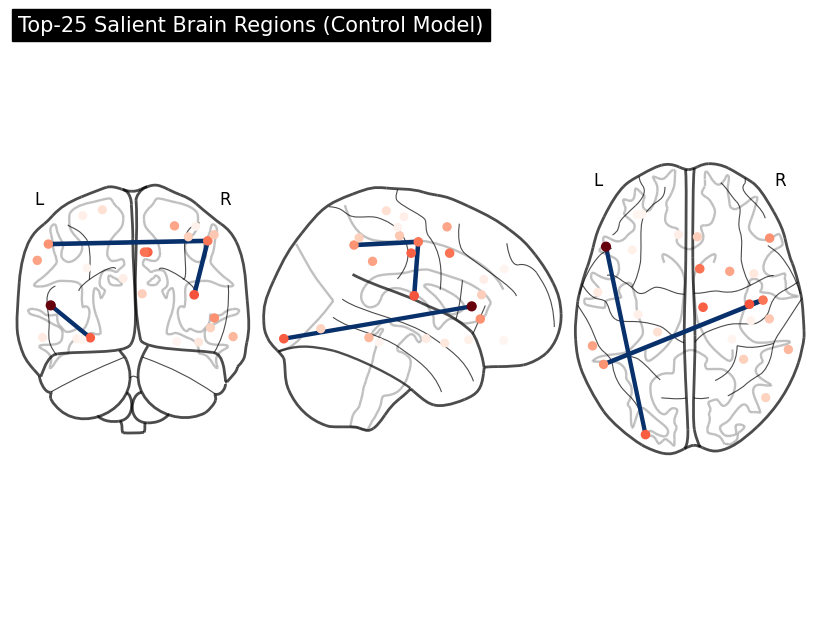

In [28]:
for k, connectome_matrix_dict in importance_matrix.items():

    connectome_matrix = connectome_matrix_dict['connectome']
    avg_saliency = connectome_matrix_dict['saliency']

    top_k = 25

    if k == 'adhd':
        title = f'Top-{top_k} Salient Brain Regions (ADHD Model)'
    else:
        title = f'Top-{top_k} Salient Brain Regions (Control Model)'


    node_importance = avg_saliency.mean(axis=0) / avg_saliency.max()
    top_node_indices = np.argsort(-node_importance)[:top_k]

    # Subset
    adj_sub = connectome_matrix[np.ix_(top_node_indices, top_node_indices)]
    coords_sub = coordinates[top_node_indices]
    importance_sub = node_importance[top_node_indices]

    normed_vals = (importance_sub - np.min(importance_sub)) / np.ptp(importance_sub)
    cmap = cm.get_cmap('Reds')
    rgb_colors = cmap(normed_vals)[:, :3]

    # Plot
    plotting.plot_connectome(
        adjacency_matrix=adj_sub,
        node_coords=coords_sub,
        node_color=rgb_colors,
        node_size=5 + 50 * importance_sub,  # scaled size
        edge_threshold='99%',  # show top 10% strongest edges
        edge_cmap=plt.get_cmap('Blues'),  # managua
        edge_vmin=0,
        edge_vmax=np.percentile(adj_sub, 99),
        title=title,
        figure=plt.figure(figsize=(8, 6))
    )

    plotting.show()